# Analysing poker players net winnings

**Methodology**

The **CRoss-Industry Standard Process for Data Mining - (CRISP-DM)** will be the method we will be using to process the data we are working on.

Our dataset is comprised of various online poker players and the statistical averages for their actions for each hand they play. We both have a good **business and data understanding** of our problem and of our dataset as we both have long histories of playing online poker. 

Our **data preperation** was made easy as we were able to download data directly from a poker database which was well formated and did not have any null values.


Modelling.....

Evaluating....

Deployment....


#### Import librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functions import *
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from xgboost import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn.cluster import KMeans
import itertools
from pprint import pprint
from sklearn.metrics import confusion_matrix
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline

#### Read csv file and preview file

In [2]:
df = pd.read_csv("Poker.csv", encoding='latin-1')
df.head(2)

,Player Name,Site,Hands,Net Won,VP$IP,PFR,3Bet,Postflop Agg%,W$WSF%,WTSD%,...,Raise River CBet,Squeeze,Raise Two Raisers,Call Two Raisers,vs 3Bet Fold,vs 3Bet Call,vs 3Bet Raise,vs 4Bet Fold,vs 4Bet Call,vs 4Bet Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


In [3]:
print("Before filtering")
winners = len(df[df["Net Won"] > 0])
losers = len(df[df["Net Won"] <= 0])
print(winners, "winners")
print(losers, "losers")
print("Winners %", winners / (winners + losers))

Before filtering
3085 winners
5737 losers
Winners % 0.3496939469508048


### If we want to use only the players with a minimum number of hands uncomment the cell below

In [4]:
pprint(list(df.columns))

['Player Name',
 'Site',
 'Hands',
 'Net Won',
 'VP$IP',
 'PFR',
 '3Bet',
 'Postflop\nAgg%',
 'W$WSF%',
 'WTSD%',
 'Won $\nat SD',
 'Flop\nCBet%',
 'Turn\nCBet%',
 'River\nCBet%',
 'Fold to\nFlop Cbet',
 'Fold to\nTurn CBet',
 'Fold to\nRiver CBet',
 'Raise\nFlop Cbet',
 'Raise\nTurn CBet',
 'Raise\nRiver CBet',
 'Squeeze',
 'Raise Two\nRaisers',
 'Call Two\nRaisers',
 'vs 3Bet\nFold',
 'vs 3Bet\nCall',
 'vs 3Bet\nRaise',
 'vs 4Bet\nFold',
 'vs 4Bet\nCall',
 'vs 4Bet\nRaise']


### Rename columns for more clarity (replacing \n by spaces)

In [5]:
df.columns = df.columns.str.replace('\n',' ')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns

In [6]:
df.head(2)

,Player_Name,Site,Hands,Net_Won,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,...,Raise_River_CBet,Squeeze,Raise_Two_Raisers,Call_Two_Raisers,vs_3Bet_Fold,vs_3Bet_Call,vs_3Bet_Raise,vs_4Bet_Fold,vs_4Bet_Call,vs_4Bet_Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


### Build the target based on Net Won vs Hands Played

In [7]:
df["winner"] = df["Net_Won"] > 0

### Drop useless columns

In [8]:
df.drop(['Player_Name', 'Site', "Hands", "Net_Won"], axis=1, inplace=True)

## Pre-processing data

#### Check data types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8822 entries, 0 to 8821
Data columns (total 26 columns):
VP$IP                 8822 non-null float64
PFR                   8822 non-null float64
3Bet                  8822 non-null float64
Postflop_Agg%         8822 non-null float64
W$WSF%                8822 non-null float64
WTSD%                 8822 non-null float64
Won_$_at_SD           8822 non-null float64
Flop_CBet%            8822 non-null float64
Turn_CBet%            8822 non-null float64
River_CBet%           8822 non-null float64
Fold_to_Flop_Cbet     8822 non-null float64
Fold_to_Turn_CBet     8822 non-null float64
Fold_to_River_CBet    8822 non-null float64
Raise_Flop_Cbet       8822 non-null float64
Raise_Turn_CBet       8822 non-null float64
Raise_River_CBet      8822 non-null float64
Squeeze               8822 non-null float64
Raise_Two_Raisers     8822 non-null float64
Call_Two_Raisers      8822 non-null float64
vs_3Bet_Fold          8822 non-null float64
vs_3Bet_Call 

All our predictors are floats (percentages), there are no missing values and our target is a boolean

#TODO: Check for number of unique values in the last 15 columns and maybe drop the ones that don't have a lot of different values meaning there were not enough occurences

### Check for class imbalance

In [10]:
winners = len(df[df["winner"] == True])
losers = len(df[df["winner"] == False])
print(winners, "winners")
print(losers, "losers")
print("Winners %", winners / (winners + losers))
print("Losers %", 1 - (winners / (winners + losers)))

3085 winners
5737 losers
Winners % 0.3496939469508048
Losers % 0.6503060530491952


The class imbalance isn't very strong, therefore we can move on with this data

### Because we don't have too many dimensions, instead of using Principal Component Analysis we will check for multicollinearities over 70 percents using our homemade function

### Check multicollinearities

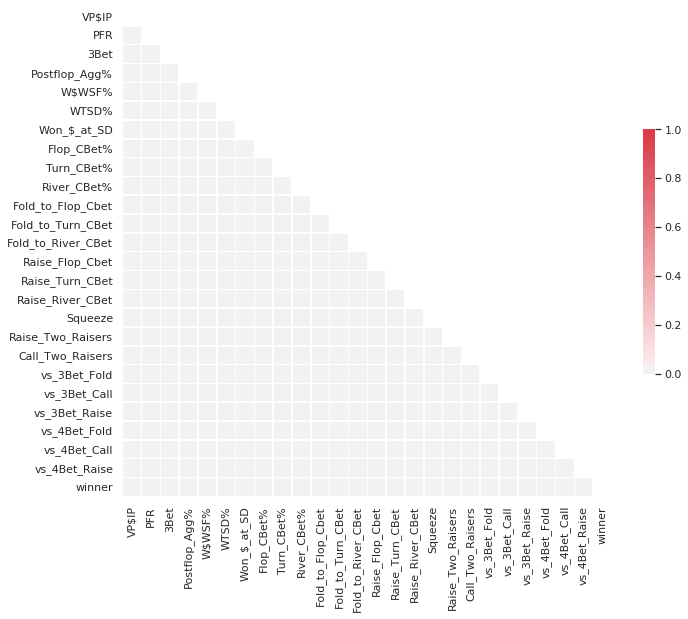

In [11]:
print_corr(df, pct=0.75)

None of our features have more than 70 percent multicollinearities

### Split the data between train and test datasets

In [12]:
labels = df["winner"]
df = df.drop(["winner"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.20, random_state=42)
X_train = X_train.reset_index().drop(["index"], axis=1)
y_train = y_train.reset_index().drop(["index"], axis=1)
X_test = X_test.reset_index().drop(["index"], axis=1)
y_test = y_test.reset_index().drop(["index"], axis=1)

## Baseline classifier using Logistic Regression

We are going to build a Logistic Regression model using a 5 fold cross validation as our baseline model

# Baseline Model using Logistic Regression Cross Validation

In [13]:
# Logistic Regression Cross Validation
baseline = LogisticRegressionCV(random_state=42, cv=5)

# Fit the pipelines
baseline.fit(X_train, y_train.values.ravel())

preds_proba = np.array(baseline.predict_proba(X_train))[:,1]

baseline_score = get_roc_auc(y_train, preds_proba)

In [14]:
baseline_score

0.8065115707068254

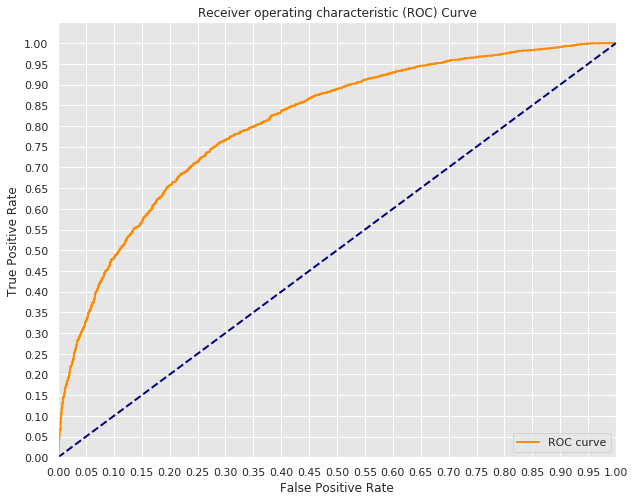

- ROC AUC Score: 0.8065
- Precision Score: 0.7264
- Recall Score: 0.4791
- Accuracy Score: 0.7527
- F1 Score: 0.5774


In [15]:
#Print ROC Curve
metrics(y_train, preds[:,1], plot=True)

In [16]:
len(y_train[y_train["winner"] == True])

2488

In [ ]:
# Plot a normalized confusion matrix
# class_names = ["Losing Player","Winning Player"]
class_names = y_train.columns
cnf_matrix = confusion_matrix(y_train, preds[:,0].round())
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Normalized confusion matrix')

# Feature Engineering

## Interactions

In [18]:
combinations = list(combinations(list(X_train.columns), 2))
interactions = []
data = X_train.copy()
for comb in combinations:
    regression = LogisticRegressionCV(random_state=42, cv=5)
    data['interaction'] = data[comb[0]] * data[comb[1]]
    regression.fit(data, y_train.values.ravel())
    preds = np.array(regression.predict_proba(data))
    score = get_roc_auc(y_train, preds[:,1])
    if score > baseline_score: interactions.append((comb[0], comb[1], round(score, 3)))
    data.drop(["interaction"], axis=1, inplace=True)

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [19]:
interactions = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10]

In [ ]:
print(interactions)

Adding top 10 interactions to the datasets

In [20]:
for dataset in [X_train, X_test]:
    for interaction in interactions:
        col1 = interaction[0]
        col2 = interaction[1]
        colname = str(col1) + "_*_" + str(col2)
        dataset[colname] = dataset[col1] * dataset[col2]

In [21]:
X_train.head()

,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,Won_$_at_SD,Flop_CBet%,Turn_CBet%,River_CBet%,...,WTSD%_*_Won_$_at_SD,Won_$_at_SD_*_River_CBet%,Won_$_at_SD_*_Raise_Two_Raisers,Won_$_at_SD_*_vs_4Bet_Call,VP$IP_*_Won_$_at_SD,VP$IP_*_Flop_CBet%,VP$IP_*_Fold_to_River_CBet,PFR_*_Flop_CBet%,PFR_*_River_CBet%,PFR_*_Fold_to_Turn_CBet
0,0.217742,0.165323,0.043478,0.339623,0.461538,0.461538,0.583333,0.666667,0.500000,0.000000,...,0.269231,0.000000,0.000000,0.000000,0.127016,0.145161,0.000000,0.110215,0.000000,0.000000
1,0.529730,0.183784,0.026316,0.588710,0.590909,0.181818,0.500000,0.714286,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.264865,0.378378,0.000000,0.131274,0.000000,0.000000
2,0.367943,0.149903,0.083039,0.363300,0.553086,0.239506,0.453608,0.850000,0.714286,0.363636,...,0.108642,0.164948,0.010549,0.181443,0.166902,0.312751,0.091986,0.127417,0.054510,0.054964
3,0.260417,0.159722,0.056000,0.345455,0.436364,0.290909,0.437500,0.500000,0.800000,1.000000,...,0.127273,0.437500,0.000000,0.437500,0.113932,0.130208,0.000000,0.079861,0.159722,0.000000
4,0.272482,0.202425,0.080512,0.251121,0.431767,0.259508,0.560345,0.525974,0.321429,0.500000,...,0.145414,0.280172,0.013836,0.147459,0.152684,0.143319,0.155704,0.106470,0.101212,0.114708


## Polynomials

Checking which polynomials have the biggest impact once added to our baseline model

In [22]:
# We'll fit 3 different polynomial regression models from degree 2 to degree 4
columns = list(X_train.columns)
polynomials = []
for col in columns:
    for degree in [2, 3, 4]:
        data = X_train.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        X_transformed = poly.fit_transform(X_train[[col]])
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X_transformed)], axis=1)
        
        #Instantiate and fit a cross validation logistic regression model to the polynomial transformed train features
        lr = LogisticRegressionCV(random_state=42, cv=5)
        lr.fit(data, y_train.values.ravel())
        
        #Build 
        preds = np.array(lr.predict_proba(data))
        score = get_roc_auc(y_train, preds[:,1])
        if score > baseline_score: polynomials.append((col, degree, round(score, 5)))

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Listing the top 10 polynomials into a dictionnary

In [23]:
polynomials = sorted(polynomials, key=lambda poly: poly[2], reverse=True)

In [24]:
polynomials_to_add = {}
for pol in polynomials:
    if pol[0] not in polynomials_to_add.keys():
        polynomials_to_add[pol[0]] = pol[1]
    if len(polynomials_to_add) == 10:
        break

In [25]:
pprint(polynomials_to_add)

{'3Bet': 3,
 'Fold_to_Turn_CBet': 3,
 'PFR': 3,
 'PFR_*_Flop_CBet%': 3,
 'Postflop_Agg%': 4,
 'Raise_Turn_CBet': 2,
 'Raise_Two_Raisers': 4,
 'Squeeze': 4,
 'VP$IP_*_Won_$_at_SD': 3,
 'Won_$_at_SD': 4}


Adding top 10 polynomials to X_train and X_test datasets

In [26]:
X_ = X_train.copy()
X_t = X_test.copy()
for col, degree in polynomials_to_add.items():
    #Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree, include_bias=False)
    #Fit and transform X_train
    X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
    X_poly_test = poly.transform(np.array(X_t[col]).reshape(-1, 1))
    #List column names including the original column
    colnames = [col]
    #Append polynomial columns names to list of columns names
    for deg in range(2, degree+1):
        colnames.append(str(col + "_^" + str(deg)))
    #Add polynomial columns to train and test data sets
    X_train = pd.concat([X_train.drop(col, axis=1),pd.DataFrame(X_poly_train, columns=colnames)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1),pd.DataFrame(X_poly_test, columns=colnames)], axis=1)

In [27]:
X_train.head()

,VP$IP,W$WSF%,WTSD%,Flop_CBet%,Turn_CBet%,River_CBet%,Fold_to_Flop_Cbet,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_River_CBet,...,Raise_Two_Raisers_^4,PFR,PFR_^2,PFR_^3,Fold_to_Turn_CBet,Fold_to_Turn_CBet_^2,Fold_to_Turn_CBet_^3,3Bet,3Bet_^2,3Bet_^3
0,0.217742,0.461538,0.461538,0.666667,0.500000,0.000000,0.285714,0.000000,0.285714,0.000000,...,0.000000e+00,0.165323,0.027332,0.004519,0.000000,0.000000,0.000000,0.043478,0.001890,0.000082
1,0.529730,0.590909,0.181818,0.714286,0.000000,0.000000,0.750000,0.000000,0.166667,0.000000,...,0.000000e+00,0.183784,0.033776,0.006208,0.000000,0.000000,0.000000,0.026316,0.000693,0.000018
2,0.367943,0.553086,0.239506,0.850000,0.714286,0.363636,0.452830,0.250000,0.056604,0.125000,...,2.925002e-07,0.149903,0.022471,0.003368,0.366667,0.134444,0.049296,0.083039,0.006895,0.000573
3,0.260417,0.436364,0.290909,0.500000,0.800000,1.000000,0.538462,0.000000,0.192308,0.000000,...,0.000000e+00,0.159722,0.025511,0.004075,0.000000,0.000000,0.000000,0.056000,0.003136,0.000176
4,0.272482,0.431767,0.259508,0.525974,0.321429,0.500000,0.535484,0.571428,0.064516,0.142857,...,3.716892e-07,0.202425,0.040976,0.008295,0.566667,0.321111,0.181963,0.080512,0.006482,0.000522


### Export X_train, X_test, y_train and y_test

In [28]:
X_train.to_csv('Datasets/X_train.csv', index = None, header=True)
X_test.to_csv('Datasets/X_test.csv', index = None, header=True)
y_train.to_csv('Datasets/y_train.csv', index = None, header=True)
y_test.to_csv('Datasets/y_test.csv', index = None, header=True)

### Import X_train, X_test, y_train and y_test

In [2]:
X_train = pd.read_csv("Datasets/X_train.csv")
X_test = pd.read_csv("Datasets/X_test.csv")
y_train = pd.read_csv("Datasets/y_train.csv")
y_test = pd.read_csv("Datasets/y_test.csv")
class_names = y_train.columns
X_train.head()

,VP$IP,W$WSF%,WTSD%,Flop_CBet%,Turn_CBet%,River_CBet%,Fold_to_Flop_Cbet,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_River_CBet,...,Raise_Two_Raisers_^4,PFR,PFR_^2,PFR_^3,Fold_to_Turn_CBet,Fold_to_Turn_CBet_^2,Fold_to_Turn_CBet_^3,3Bet,3Bet_^2,3Bet_^3
0,0.217742,0.461538,0.461538,0.666667,0.500000,0.000000,0.285714,0.000000,0.285714,0.000000,...,0.000000e+00,0.165323,0.027332,0.004519,0.000000,0.000000,0.000000,0.043478,0.001890,0.000082
1,0.529730,0.590909,0.181818,0.714286,0.000000,0.000000,0.750000,0.000000,0.166667,0.000000,...,0.000000e+00,0.183784,0.033776,0.006208,0.000000,0.000000,0.000000,0.026316,0.000693,0.000018
2,0.367943,0.553086,0.239506,0.850000,0.714286,0.363636,0.452830,0.250000,0.056604,0.125000,...,2.925002e-07,0.149903,0.022471,0.003368,0.366667,0.134444,0.049296,0.083039,0.006895,0.000573
3,0.260417,0.436364,0.290909,0.500000,0.800000,1.000000,0.538462,0.000000,0.192308,0.000000,...,0.000000e+00,0.159722,0.025511,0.004075,0.000000,0.000000,0.000000,0.056000,0.003136,0.000176
4,0.272482,0.431767,0.259508,0.525974,0.321429,0.500000,0.535484,0.571428,0.064516,0.142857,...,3.716892e-07,0.202425,0.040976,0.008295,0.566667,0.321111,0.181963,0.080512,0.006482,0.000522


## Build pipelines

In [5]:
# Defining pipelines
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier(n_neighbors=11))])
pipe_tree = Pipeline([('mms', MinMaxScaler()),('tree', DecisionTreeClassifier(max_depth=6, random_state=123))])
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(max_depth=6, random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_knn, pipe_tree, pipe_rf]
pipeline_names = ['K-Nearest Neighbors','Decision Tree','Random Forest']

# Fit the different models
for pipe in pipelines:
    pipe.fit(X_train, y_train.values.ravel())

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



K-Nearest Neighbors pipeline metrics on train set:


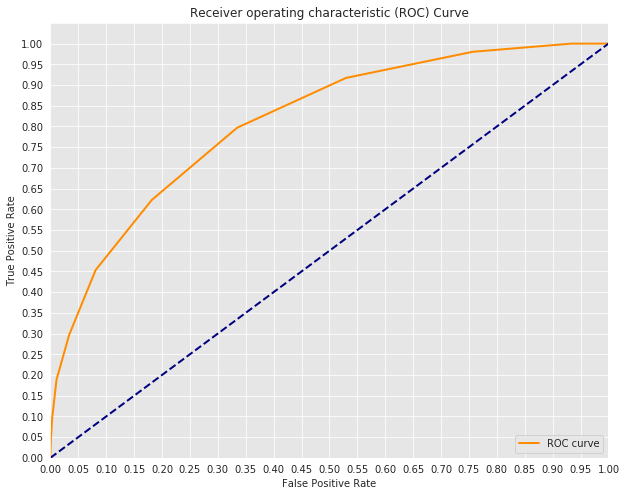

ROC AUC Score: 0.8115

------- Metrics for default threshold 0.5 -------
- Precision Score: 0.753
- Recall Score: 0.4534
- Accuracy Score: 0.7549
- F1 Score: 0.566



In [6]:
print(f"\n{pipeline_names[0]} pipeline metrics on train set:")
preds = np.array(pipelines[0].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)


Decision Tree pipeline metrics on train set:


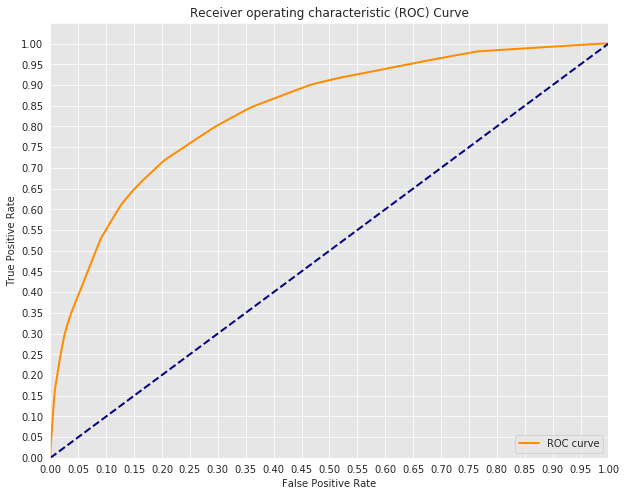

ROC AUC Score: 0.8344

------- Metrics for default threshold 0.5 -------
- Precision Score: 0.7252
- Recall Score: 0.6089
- Accuracy Score: 0.7808
- F1 Score: 0.662



In [7]:
print(f"\n{pipeline_names[1]} pipeline metrics on train set:")
preds = np.array(pipelines[1].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)

Random Forest pipeline metrics on train set:


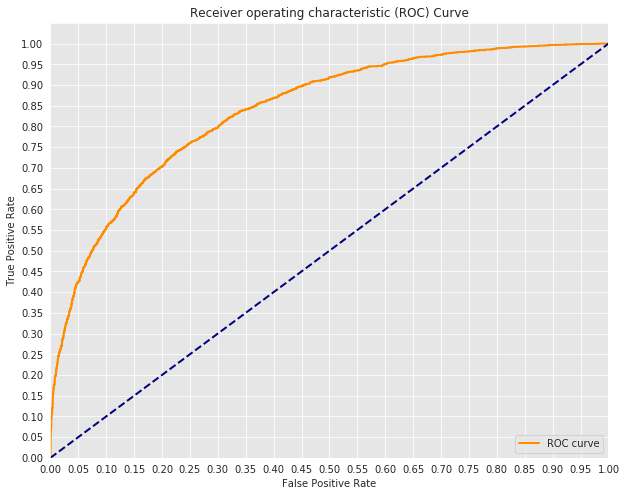

ROC AUC Score: 0.8394

------- Metrics for default threshold 0.5 -------
- Precision Score: 0.7406
- Recall Score: 0.5679
- Accuracy Score: 0.7775
- F1 Score: 0.6429



In [8]:
print(f"{pipeline_names[2]} pipeline metrics on train set:")
preds = np.array(pipelines[2].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)

## K-Nearest-Neighbors Pipeline with Grid Search

In [9]:
# Construct pipeline
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier())])

# Set grid search params
param_grid_knn = [
    {'knn__n_neighbors': list(range(1,100,2))}
]

# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit using grid search
gs_knn.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mms',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'knn


Grid search K-Nearest Neighbors metrics on train set


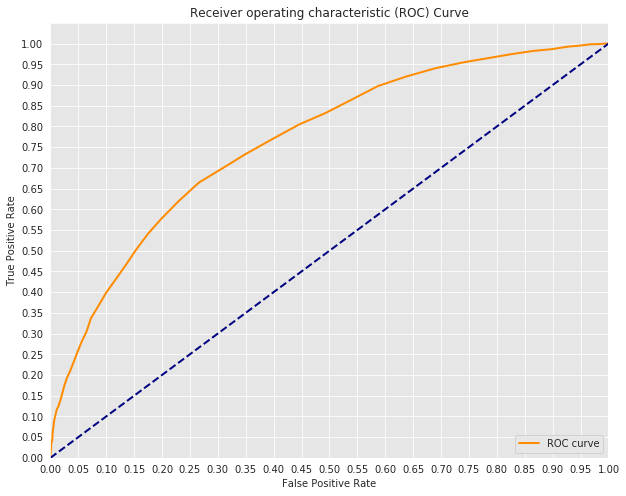

ROC AUC Score: 0.765

------- Metrics for default threshold 0.5 -------
- Precision Score: 0.7424
- Recall Score: 0.2536
- Accuracy Score: 0.7058
- F1 Score: 0.3781


Validation ROC AUC: 0.742

Best params:
 {'knn__n_neighbors': 81}


In [10]:
preds_knn = np.array(gs_knn.predict_proba(X_train))

print("\nGrid search K-Nearest Neighbors metrics on train set")
metrics(y_train, preds_knn[:,1], plot=True)

# Validation ROC AUC
print('\nValidation ROC AUC: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

## Random Forest Classifier Pipeline with Grid Search

In [11]:
# Construct pipeline
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(random_state=123))])

# Set grid search params
param_grid_forest = [
    {'rf__n_estimators': [10, 20],
     'rf__criterion': ['entropy'],
     'rf__max_depth': [4, 5, 6],
#      'rf__max_features': [35, 45]
#      'rf__min_samples_leaf':[0.05 ,0.1, 0.2],
#      'rf__samples_split':[0.05 ,0.1, 0.2]
    }
]

# print(pipe_rf.get_params().keys())

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_forest, scoring='roc_auc', cv=5, verbose=2, return_train_score=True)

# # Fit using grid search
gs_rf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20, total=   0.2s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20, total=   0.2s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20 .....
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__n_estimators=20, total=   0.2s
[CV] rf

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mms',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
  


Grid search Random Forest Classifier metrics on train set


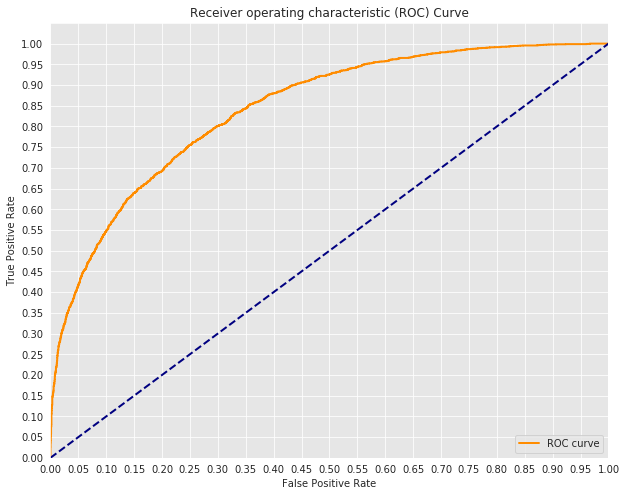

ROC AUC Score: 0.8418

------- Metrics for default threshold 0.5 -------
- Precision Score: 0.7399
- Recall Score: 0.5683
- Accuracy Score: 0.7774
- F1 Score: 0.6429


The validation ROC AUC is: 0.802

Best params:
 {'rf__criterion': 'entropy', 'rf__max_depth': 6, 'rf__n_estimators': 20}


In [12]:
preds_rf = np.array(gs_rf.predict_proba(X_train))

print("\nGrid search Random Forest Classifier metrics on train set")
metrics(y_train, preds_rf[:,1], plot=True)

# Validation ROC AUC
print('\nThe validation ROC AUC is: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

## XGBoost Classifier Pipeline with Grid Search

In [3]:
# Construct pipeline
pipe_xgb = Pipeline([('mms', MinMaxScaler()),('xgb', XGBClassifier(random_state=123))])

# Set grid search params
param_grid_xgb = {
#     'xgb__min_child_weight': [1, 5, 10],
#     'xgb__gamma': [0.5, 1, 2, 5],
#     'xgb__subsample': [0.6, 0.8, 1.0],
#     'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5, 6]
}

# Construct grid search
gs_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=param_grid_xgb, scoring='roc_auc', cv=5, verbose=0, return_train_score=True)

# Fit using grid search
gs_xgb.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mms',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                            


Grid search XGBoost Classifier metrics on TRAIN DATASET


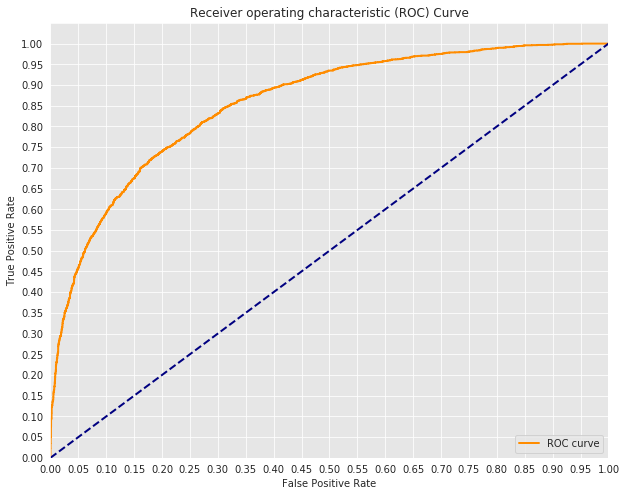

ROC AUC Score: 0.8555099056341529

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7484123106985833
- Recall Score: 0.6157556270096463
- Accuracy Score: 0.7915544849086014
- F1 Score: 0.6756339581036384

----------------------------------------------------------------------------------------------------

Grid search XGBoost Classifier metrics on TEST DATASET

ROC AUC Score: 0.805003900782451

------- Metrics for threshold 0.5 -------
- Precision Score: 0.6555323590814196
- Recall Score: 0.525963149078727
- Accuracy Score: 0.7461756373937677
- F1 Score: 0.5836431226765799

----------------------------------------------------------------------------------------------------
Validation ROC AUC: 0.811
----------------------------------------------------------------------------------------------------

Best parameters for XGBoost:
 {'xgb__max_depth': 3}


In [4]:
preds_proba_xgb = np.array(gs_xgb.predict_proba(X_train))[:,1]
preds_proba_xgb_test = np.array(gs_xgb.predict_proba(X_test))[:,1]

# Train ROC AUC
print("\nGrid search XGBoost Classifier metrics on TRAIN DATASET")
metrics(y_train, preds_proba_xgb, plot=True)
print(f"{'-'*100}")

print("\nGrid search XGBoost Classifier metrics on TEST DATASET\n")
metrics(y_test, preds_proba_xgb_test, plot=False)
print(f"{'-'*100}")

# Validation ROC AUC
print('Validation ROC AUC: %.3f' % gs_xgb.best_score_)
print(f"{'-'*100}")

# Best params
print('\nBest parameters for XGBoost:\n', gs_xgb.best_params_)

### Plotting XGBoost Tree

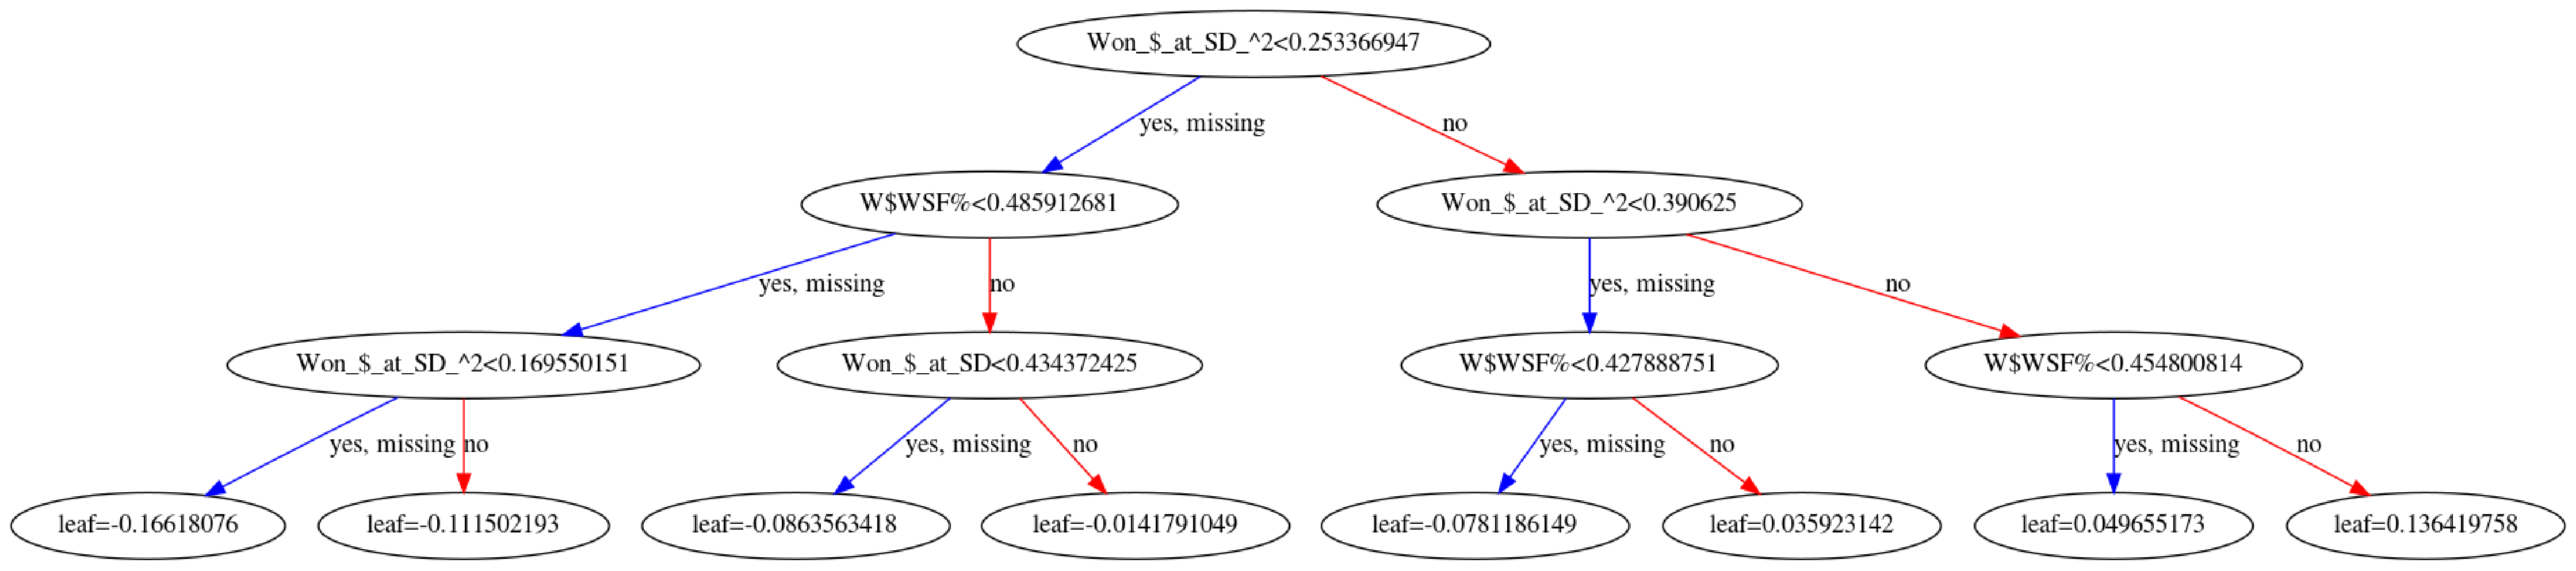

In [5]:
xgb_clf = XGBClassifier(**gs_xgb.best_params_, random_state=123)
xgb_clf.fit(X_train, y_train.values.ravel())
rcParams['figure.figsize'] = 80,120
# Plot XGBoost tree
plot_tree(xgb_clf)

# - First objective: classify good players accuretely in small stakes games

When playing a small stakes game we know that most players are probably losing players, to the point that we can consider players as losing player by default.
Knowing this we would like to recognize the winning players in order to avoid playing against them.

Since we don't want to miss value by not playing against a player that was miss classified as a good player we need to be quite certain that our classifier will tell us that a player is a winning player when he actually is!

### Calculating optimal threshold for small stakes

In [6]:
prevalence = 0.25
CostFP_minus_CostTN = 6
CostFN_minus_CostTP = 6
threshold_small_stakes = threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y=y_train, y_hat=preds_proba_xgb)
print("Threshold small stakes:", round(threshold_small_stakes, 3))

Threshold small stakes: 0.584


### Plotting Confusion Matrix for small stakes

Confusion matrix, without normalization
[[4286  283]
 [1234 1254]]


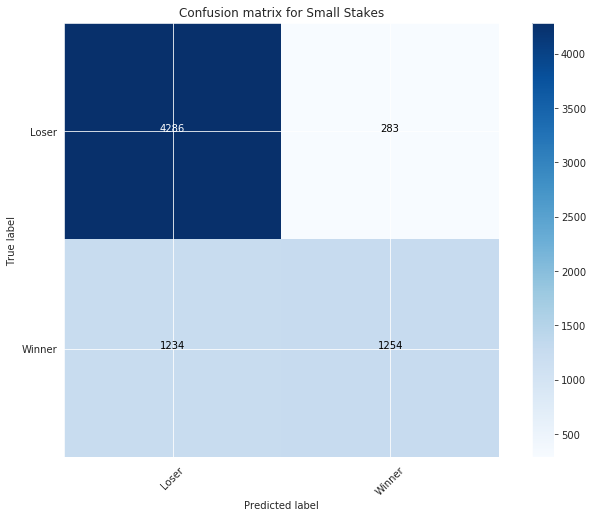

Precision score for winners: 0.78 %


In [7]:
# Plot a normalized confusion matrix
class_names = ["Loser", "Winner"]
preds_proba = np.array(gs_xgb.predict_proba(X_train))[:,1]
plt.figure(figsize=(12,8))
cm_s = plot_confusion_matrix(labels=y_train, preds_proba=preds_proba, threshold=threshold_small_stakes, classes=class_names, normalize=False, title='Confusion matrix for Small Stakes')
print(f"Precision score for winners: {round(cm_s[0][0] / (cm_s[0][0] + cm_s[1][0]), 2)} %")

### Conclusion small stakes

Our classifier will only tell us half of the winners on the table but will make very few mistakes when trying to predict winning players but

# - Second objective: classify bad players accuretely in high stakes games

When playing a high stakes game we know that most players are winning players.
Knowing this we would like to recognize the winning players in order to avoid playing against them.

Since we don't want to miss value by not playing against a player that was miss classified as a good player we need to be quite certain that our classifier will tell us that a player is a winning player when he actually is!

## Calculating optimal threshold for high stakes

In [8]:
prevalence = 0.75
CostFP_minus_CostTN = 4
CostFN_minus_CostTP = 4
threshold_high_stakes = threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y=y_train, y_hat=preds_proba_xgb)
print("Threshold high stakes:", round(threshold_high_stakes, 3))

Threshold high stakes: 0.18


## Plotting Confusion Matrix for high stakes

Normalized confusion matrix
[[0.48106807 0.51893193]
 [0.05827974 0.94172026]]


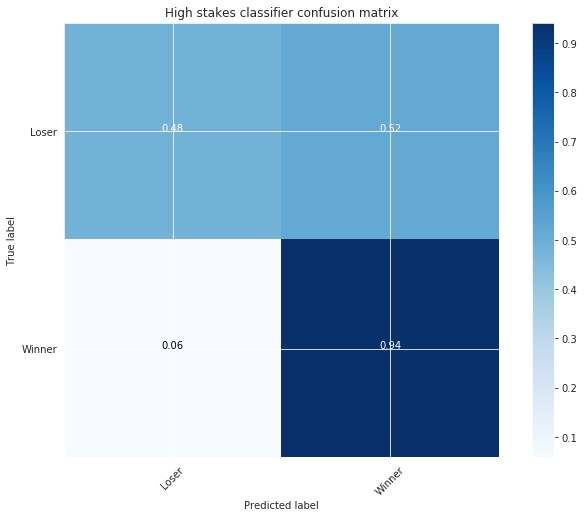

Precision score for losers: 0.94 %


In [9]:
# Plot a normalized confusion matrix
class_names = ["Loser", "Winner"]
preds_proba = np.array(gs_xgb.predict_proba(X_train))[:,1]
plt.figure(figsize=(12,8))
cm_h = plot_confusion_matrix(labels=y_train, preds_proba=preds_proba, threshold=threshold_high_stakes, classes=class_names, normalize=True, title='High stakes classifier confusion matrix')
print(f"Precision score for losers: {round(cm_h[0][0] / (cm_h[0][0] + cm_h[1][0]), 2)} %")

# Conclusions

TODO

comment notebook

visualisation trees

prediction function

readme

slides